Compute pairwise correlations of neuronal population, and visualize the activity of a pair of cells in the state space.

In [1]:
import os
from glob import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf

In [2]:
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': glob(os.path.join(folder,'Similar*.hdf5'))}
p = 0
exps = ['Enriched','Dissimilar','Similar']
datapath = alldata[exps[p]][2]
day = 1  # Recording days, None for all days
min_rate = 1/60  # Minimum transient rate for active cells

In [3]:
data, cells, days, ctx, selected_cells = get_data_bis(
    datapath, day=day, min_rate=min_rate, select='or', verbose=True)

with h5py.File(datapath, 'r') as f:
    yrange = f['params/yrange'][()]  # Dataset dependent

ncell = data['F'][0].shape[0]    
print('Recording days:', days)
print('Context fam/nov:', ctx)

------------------------------------
Total cells: 91
Active cells: 75
Proportion of active cells 82.42 %
Active in both 38.46 %
Active exclusively in Fam 20.88 %
Active exclusively in Nov 23.08 %
------------------------------------
Recording days: [1 1 1 1]
Context fam/nov: [0 1 0 1]


## Compute pairwise correlations
Kendall's tau correlation between each pair of cells with activity averaged over each trial.

In [4]:
## Prepare data (tunig: list of categories)
ybin = 1  # Number of spatial bins
ysigma = 0  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves

tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                           spike=False, transient=True)

## Group tuning by context
nday = len(set(days))
nctx = len(set(ctx))
activity = []  # List of contexts and maybe days
for d in range(nday):
    for c in range(nctx):
        ks = np.where((days==(d+1)) & (ctx==c))[0]
        M = np.concatenate([tuning[k] for k in ks], axis=2)  # (ncell, ybin, ntrial)
        activity.append(np.transpose(M, [2,1,0]))  # (ntrial, ybin, ncell)

In [5]:
# %% Functions computing the population correlation vector (PCorr)
def shuffle_trial(Flist, seed=0):
    '''For each cell, shuffle the trial ID but keep the spatial tuning.
    
    Parameters
    ----------
    Flist : list of arrays of shape (ntrial, ybin, ncell)
        Activity arrays in a list of contexts (and maybe of days).
    
    Returns
    -------
    Fshuffled : list of arrays of shape (ntrial, ybin, ncell)
        Activity arrays with trial order shuffled for each cell.
    '''
    rng = np.random.default_rng(seed)
    Fshuffled = []
    for F in Flist:
        Fsh = F.copy()  # (ntrial, ybin, ncell)
        for i in range(F.shape[2]):
            Fsh[:,:,i] = rng.permutation(F[:,:,i])  # Shuffle by rows (trials)
        Fshuffled.append(Fsh)
    return Fshuffled

def compute_pcorr(activity):
    '''
    Parameters
    ----------
    activity : list of arrays of shape (ncell, ybin, ntrial)
        Activity arrays in a list of contexts (and maybe of days).
        
    Returns
    -------
    Pcorr : list of arrays of shape (ncell, ncell)
        Pairwise correlations
    Pval : list of arrays of shape (ncell, ncell)
        Corresponding p-values
    '''
    Pcorr, Pval = [], []
    for M in activity:  # (ncell, ybin, ntrial)
        ncell = M.shape[2]
        A = np.reshape(M, (-1,ncell)).T  # (ncell, ybin*ntrial)
        pcorr = np.ones((ncell,)*2)  # Pairwise correlation
        pval = np.ones((ncell,)*2)  # Corresponding p-value
        for i in range(ncell):
            for j in range(i+1,ncell):
                # pcorr[i,j], pval[i,j] = stats.pearsonr(A[i], A[j])
                # pcorr[i,j], pval[i,j] = stats.spearmanr(A[i], A[j])
                pcorr[i,j], pval[i,j] = stats.kendalltau(A[i], A[j])
                pcorr[j,i] = pcorr[i,j]
                pval[j,i] = pval[i,j]
        Pcorr.append(pcorr)
        Pval.append(pval)
        
    return Pcorr, Pval

In [6]:
# %% Run for both original/shuffled
Pcorr, Pval = compute_pcorr(activity)
Pcorr2 = compute_pcorr(shuffle_trial(activity, seed=0))[0]

paircorr = np.vstack([P[np.triu_indices(ncell, k=1)] for P in Pcorr])  # (nctx*nday, # cell pairs)
paircorr2 = np.vstack([P[np.triu_indices(ncell, k=1)] for P in Pcorr2])

print('-'*32)
print('Original means (Fam, Nov): (%.4g, %.4g)' % (np.nanmean(paircorr[0]), np.nanmean(paircorr[1])))
print('Shuffled means (Fam, Nov): (%.4g, %.4g)' % (np.nanmean(paircorr2[0]), np.nanmean(paircorr2[1])))

coactive = paircorr[:, np.all(np.isfinite(paircorr), axis=0)]
coactive2 = paircorr2[:, np.all(np.isfinite(paircorr2), axis=0)]

print('-'*32)
print('Original Fam vs Nov: r=%.4g, p=%.4g' % stats.pearsonr(coactive[0], coactive[1]))
print('Shuffled Fam vs Nov: r=%.4g, p=%.4g' % stats.pearsonr(coactive2[0], coactive2[1]))
print('Fam original vs shuffled: r=%.4g, p=%.4g' % stats.pearsonr(coactive[0], coactive2[0]))
print('Nov original vs shuffled: r=%.4g, p=%.4g' % stats.pearsonr(coactive[1], coactive2[1]))

--------------------------------
Original means (Fam, Nov): (0.0359, 0.01314)
Shuffled means (Fam, Nov): (0.002721, -0.0003807)
--------------------------------
Original Fam vs Nov: r=0.01938, p=0.314
Shuffled Fam vs Nov: r=-0.004924, p=0.7981
Fam original vs shuffled: r=0.02525, p=0.1895
Nov original vs shuffled: r=0.02291, p=0.2339


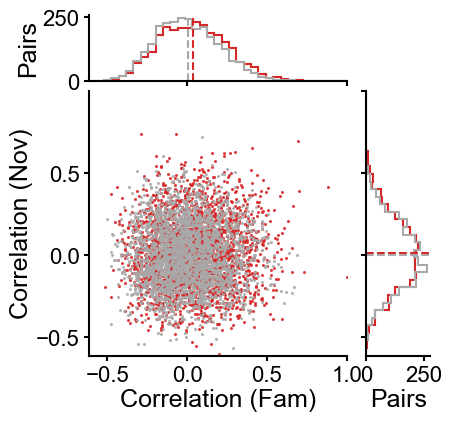

In [10]:
# %% Joint plot
vmin = max(np.min(coactive)-0.01,-1)
vmax = min(np.max(coactive)+0.01,1)
bins = np.linspace(vmin,vmax,36)
colors = ['tab:red','darkgray']

fig, axs = plt.subplots(2, 2, figsize=(4.8,4.5),
                        gridspec_kw={'height_ratios':[1,4],
                                     'width_ratios':[4,1]})
axs[1,0].scatter(coactive[0], coactive[1], c=colors[0], s=1.6, alpha=0.8, rasterized=True)
axs[1,0].scatter(coactive2[0], coactive2[1], c=colors[1], s=1.6, alpha=0.8, rasterized=True)
axs[1,0].set(xlim=[vmin,vmax], xticks=[-0.5,0,0.5,1], xlabel='Correlation (Fam)',
             ylim=[vmin,vmax], yticks=[-0.5,0,0.5], ylabel='Correlation (Nov)')              

axs[0,0].axvline(np.mean(coactive[0]), ls='--', c=colors[0])
axs[0,0].axvline(np.mean(coactive2[0]), ls='--', c=colors[1])
axs[0,0].hist(coactive[0], bins=bins, histtype='step', edgecolor=colors[0], lw=1.5)  # Fam, original
axs[0,0].hist(coactive2[0], bins=bins, histtype='step', edgecolor=colors[1], lw=1.5)  # Fam, original
axs[0,0].set(xlim=[vmin,vmax], xticklabels=[], ylabel='Pairs')

axs[1,1].axhline(np.mean(coactive[1]), ls='--', c=colors[0])
axs[1,1].axhline(np.mean(coactive2[1]), ls='--', c=colors[1])
axs[1,1].hist(coactive[1], bins=bins, histtype='step', edgecolor=colors[0], lw=1.5, orientation='horizontal')  # Nov, original
axs[1,1].hist(coactive2[1], bins=bins, histtype='step', edgecolor=colors[1], lw=1.5, orientation='horizontal')  # Nov, original
axs[1,1].set(ylim=[vmin,vmax], yticklabels=[], xlabel='Pairs')
axs[0,1].set_axis_off()
fig.tight_layout()
fig.subplots_adjust(hspace=0.06, wspace=0.12)
fig.savefig('Pair correlation.svg', dpi=200)

## Study for pairs of spatial tunings

In [8]:
ybin = 80  # Number of spatial bins
ysigma = 1  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves
pval_thr = 0.01

significant = (cells['si_pvalue'] <= pval_thr)
tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                           spike=False, transient=True)

In [28]:
def get_indices(ind, n):
    '''Unravel index from the flatten upper triangular part of a square matrix
    '''
    i = 0
    k = n - 1
    while ind >= k:
        ind -= k
        i += 1
        k -= 1
    return i, i+1+ind

def set_frame(ax, c='r', lw=2):
    
    ax.set_frame_on(True)
    for spine in ax.spines.values():
        spine.set(visible=True, edgecolor=c, linewidth=lw)
        
def display_pair(M, pair, place_cells, selected_cells=None, color='r', lw=2):
    ''' M : array of shape (ncell, ybin, ntrial)
    '''
    i, j = pair
    ncell, ny, nt = M.shape
    if selected_cells is None:
        selected_cells = np.arange(ncell)
    yedges = np.linspace(0,4,ny+1)
    ycenters = (yedges[:-1] + yedges[1:])/2
    c = np.repeat(ycenters, nt)
    
    fig, axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(2.3,3.8))
    fig.subplots_adjust(bottom=0.56, wspace=0.05)
    axs[0].imshow(M[i].T, cmap='inferno', interpolation='none')
    axs[1].imshow(M[j].T, cmap='inferno', interpolation='none')
    for ax in axs:
        ax.set(xticks=[], yticks=[], frame_on=False, aspect='auto')
    
    ## If place cells, highlight with a colored frame
    if place_cells[i]:
        set_frame(axs[0], c=color, lw=lw)
    if place_cells[j]:
        set_frame(axs[1], c=color, lw=lw)    
    
    ax = fig.add_axes([0.34,0.15,0.46,0.28])  # (left, bottom, width, height)
    x = M[i].ravel()
    y = M[j].ravel()
    ind = np.any(np.vstack([x,y])>0, axis=0)
    ax.scatter(x[ind], y[ind], c=c[ind], s=16, cmap='jet', alpha=0.8, vmin=0, vmax=4)  # rasterized=True    
    ax.set(xlabel=f'Activity cell {selected_cells[i]}',
           ylabel=f'Activity cell {selected_cells[j]}',
           xticks=[0,1], yticks=[0,1])
    
    return fig, axs, ax

In [ ]:
# %% Display all tuning maps
c = 1
nrow, ncol = 10, 10
M = np.concatenate([tuning[k] for k in np.where(ctx==c)[0]], axis=2)

nfig = int(np.ceil(M.shape[0]/(nrow*ncol)))
count = 0
for n in range(nfig):
    fig, axs = plt.subplots(nrow,ncol,sharex=True,sharey=True,figsize=(12,16))
    for row in range(nrow):
        for col in range(ncol):
            if count < ncell:
                axs[row,col].imshow(M[count].T, cmap='inferno', interpolation='none')
                axs[row,col].set(xticks=[], yticks=[], frame_on=False, aspect='auto')
                if significant[count,c]:
                    set_frame(axs[row,col], c='y', lw=3)
            else:
                axs[row,col].set_axis_off()
            count += 1
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    # fig.savefig('All tuning nov enriched3.png')

In [11]:
# %% Plot example pairs
c = 0
M = np.concatenate([tuning[k] for k in np.where(ctx==c)[0]], axis=2)
print(M.shape)

(75, 80, 20)


tau = -0.041


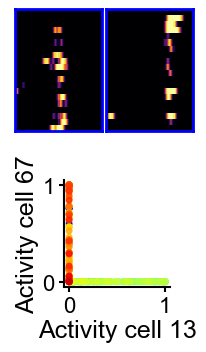

In [29]:
i, j = 9, 55
fig, axs, ax = display_pair(M, (i,j), significant[:,c], selected_cells, color='b', lw=2)
print('tau = %.3f' % Pcorr[c][i,j])
fig.savefig('Pair enriched3 fam (1).svg')

tau = 0.210


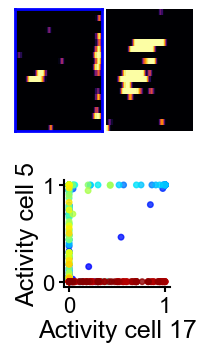

In [30]:
i, j = 13, 4
fig, axs, ax = display_pair(M, (i,j), significant[:,c], selected_cells, color='b', lw=2)
print('tau = %.3f' % Pcorr[c][i,j])
fig.savefig('Pair enriched3 fam (2).svg')

tau = 0.180


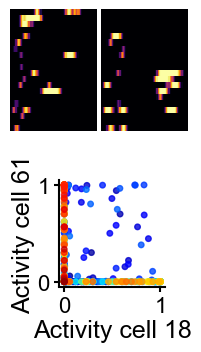

In [31]:
i, j = 14, 49
fig, axs, ax = display_pair(M, (i,j), significant[:,c], selected_cells, color='b', lw=2)
print('tau = %.3f' % Pcorr[c][i,j])
fig.savefig('Pair enriched3 fam (3).svg')